In [1]:
import os
import rasterio
import numpy as np
from PIL import Image
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
def calculate_evi(red, blue, nir, scale_factor=2.5, canopy_background_adjustment=1.0):
    # Convert input bands to float to avoid integer division
    red = red.astype(float)
    blue = blue.astype(float)
    nir = nir.astype(float)
    evi = scale_factor * ((nir - red) / (nir + 2.4 * red  + 1))
    return evi
# List to store EVI values
def read_images(folder_path):
    evi_values = []
    filee=os.listdir(folder_path)
    filee.sort()
    for filename in filee:
        if filename.endswith(".jpeg"):  # Assuming images are in jpg format
            img_path = os.path.join(folder_path, filename)
            with rasterio.open(img_path) as src:
                red=src.read(3)
                redd=np.mean(red)
                blue = src.read(1)
                bluee=np.mean(blue)
                nir = src.read(2)
                nirr=np.mean(nir)
            
            evi = calculate_evi(redd, bluee, nirr)
            evi_values.append(evi)
    return evi_values
image_folder = r"D:\dataset"
time_series_data = read_images(image_folder)
print(time_series_data)
data  = pd.Series(time_series_data, index=pd.date_range("4-1-2017", periods=len(time_series_data), freq="M"), 
                  name="time series")
time_series_data  = data.iloc[:68]
test_data = data.iloc[68:]
print(time_series_data )
print('testttt data')
print(test_data)
seasonal_periods = 12  # Monthly data
harmonics_matrix = np.column_stack([np.sin(2 * np.pi * i * np.arange(len(time_series_data)) / seasonal_periods) 
                                    for i in range(1, seasonal_periods + 1)])

# Create design matrix including harmonic terms
design_matrix = sm.add_constant(harmonics_matrix)

# Fit the dynamic harmonic regression model
model = sm.OLS(time_series_data.values, design_matrix)
results = model.fit()

# Generate forecasts
forecast_horizon = 12  # Forecasting for the next 12 periods

# Create forecast dates
forecast_dates = pd.date_range(start=time_series_data.index[-1], periods=forecast_horizon + 1, freq='M')[1:]  # Exclude last date of the original series

# Create harmonic terms matrix for forecast horizon
forecast_harmonics_matrix = np.column_stack([np.sin(2 * np.pi * i * np.arange(len(time_series_data), 
        len(time_series_data) + forecast_horizon) / seasonal_periods) for i in range(1, seasonal_periods + 1)])

# Create forecast design matrix including harmonic terms
forecast_design_matrix = sm.add_constant(forecast_harmonics_matrix)

# Generate forecast values
forecast_values = results.predict(forecast_design_matrix)

# Construct forecast DataFrame
forecast = pd.Series(forecast_values, index=forecast_dates, name='forecast')

print("Dynamic Harmonic Regression Forecast:")
print(forecast)


C:\Users\usham\anaconda3\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[0.03880722906235728, 0.1932331645469372, 0.054830578374401126, 0.01196201034306581, 0.20224658148422922, 0.1618774829636667, 0.08664913300348409, 0.10445726971325267, 0.1790644018029906, 0.03654252961736779, -0.010283477499640242, 0.11966832044835911, 0.0759892562845943, 0.15661699711697513, 0.04103382669442788, 0.18892103796799692, 0.20213081706342464, 0.21391424198258388, 0.23267051956510423, 0.22170577415637094, 0.2288209416912162, 0.22878427432752463, 0.2352530955575997, 0.2620413762009714, 0.25897518868393654, 0.14600227931661938, 0.11227629055472604, 0.20793388305124696, 0.27050537650835516, 0.25967456605785805, 0.17829152291083084, 0.1310559510258276, 0.16541047527689318, 0.2072227606113774, 0.2585425942585074, 0.2267363941275875, 0.2623693162626111, 0.1828651694741142, 0.1776258187807038, 0.12863198148901503, 0.15632150717367246, -0.028211033365832333, 0.05814255285293505, 0.0032395503378168868, 0.20521366288906942, 0.104661180621923, 0.25767742409035577, 0.27166323827994676, 

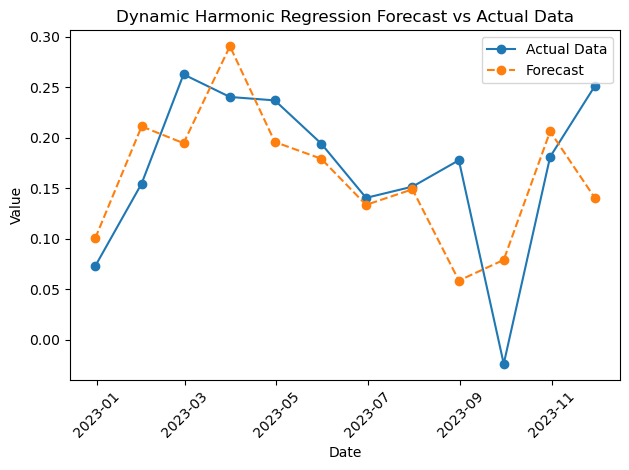

In [2]:
import matplotlib.pyplot as plt
plt.plot(test_data.index, test_data.values, label='Actual Data', marker='o')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--', marker='o')
plt.title('Dynamic Harmonic Regression Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [3]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_data, forecast)
print("Mean Absolute Error:", mae)
percentage_accuracy = 100 - (mae / np.mean(test_data)) * 100
print("Percentage Accuracy:", percentage_accuracy, "%")
print("PCC :",np.abs(np.corrcoef(test_data, forecast)[0, 1]))
print("RMSE :",np.sqrt(mean_squared_error(test_data, forecast)))

Mean Absolute Error: 0.052213225583420265
Percentage Accuracy: 69.28824533304696 %
PCC : 0.599310719863862
RMSE : 0.06511104314188855
